In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
import seaborn as sns
import matplotlib.patches as mpatches 


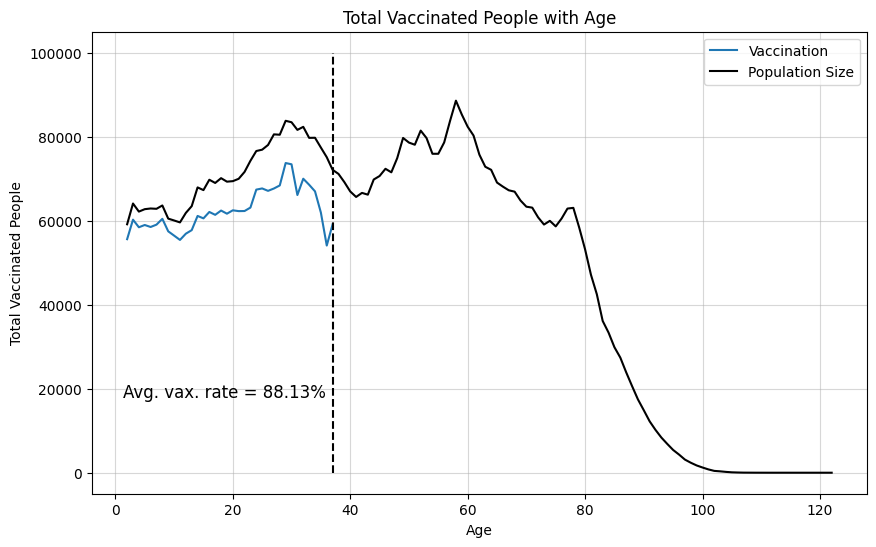

Overall immune fraction = 94.9
Vaccinated immune fraction = 88.13


In [172]:
# Read the Excel file into a pandas DataFrame
df = pd.read_csv('Data/MMR1_cov_dk_2022.csv', sep=";", thousands='.')

# Convert vaccination coverage to a decimal 
df['VACCINATIONRATE'] = df['VACCINATIONRATE'] / 100

# Calculate the total number of vaccinated people
df['Total Vaccinated'] = df['POPULATION'] * df['VACCINATIONRATE']

#Update to current age
df['AGE'] = df['AGE']+2


#Vacciantion rate for 1987 and onwards

#Just after 1987
df_above = df[df['BIRTH YEAR'] >= 1987]

df_before= df[df['BIRTH YEAR'] < 1987]

#Weight rates by population number
immune_post1987 = np.average(np.asarray(df_above['VACCINATIONRATE']), weights= np.asarray(df_above['POPULATION']))

#Same for all data
immune_all = np.average(np.asarray(df['VACCINATIONRATE']), weights= np.asarray(df['POPULATION']))

# Plot the total vaccinated people as a function of birth year
plt.figure(figsize=(10, 6))
plt.plot(df_above['AGE'], df_above['Total Vaccinated'], linestyle='-', label = "Vaccination")
plt.plot(df['AGE'], df['POPULATION'], 'k-', label = "Population Size")
plt.title('Total Vaccinated People with Age')
plt.xlabel('Age')
plt.ylabel('Total Vaccinated People')
plt.grid(True, alpha = .5)
plt.vlines(x = 2022-1987+2, ymin = 0, ymax = 100000, color = "black", linestyles="--")

plt.text(0.04, 0.2, f'Avg. vax. rate = {round(immune_post1987*100,2)}%', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='left')


plt.legend()
plt.savefig("Plots/VaxvsPop.pdf", dpi = 400)
plt.show()


print(f'Overall immune fraction = {round(immune_all*100,2)}')
print(f'Vaccinated immune fraction = {round(immune_post1987*100,2)}')



The above asssumes that everyone before 1987 are immunized against measles naturally, and no natural immunization occures after that point.

## Better estimate

Assuming now that only a fraction of children brafore 1987 have aquire natural immunization, and taking into account all "12-year" vaccinations that occure within 12 years of 1987 (before 1999), which assume are only give to childre who have not gotten natural immunity (although this is certainly not be true), we should get a better (and lower) estimate of the immunity in the 2022 DK population.


Assuming the fraction of immune people as a function of age takes the form 

$$R(t) = 1-e^{-\lambda t}$$

where $\lambda$ is the force of infection (assumed for simplicity not to be age depedent). We obtain $\lambda$ by assuming some $R_0$ and solving for the force of infection in 

$$R_0 = \frac{\lambda L}{1-\exp(-\lambda L)}$$

where L is the assumed cutoff of age in a type I age-model (Anderson & May p.67 on)


In [228]:
#Immunity by age function
natural_immunity = lambda t, f_inf: 1-np.exp(-f_inf*t)

# Define the function whose root we want to find
def equation(lambda_, R0, L):
    return R0 * (1 - np.exp(-lambda_ * L)) - lambda_ * L

# Parameters (you can change these values)
R0 = 12.0  # Reproduction number
L = 80.0   #80 years seems about right for now (see above plot of population)

# Initial guess for lambda
lambda_initial_guess = R0 / L

# Solve for lambda using fsolve
lambda_solution, info, ier, mesg = fsolve(equation, lambda_initial_guess, args=(R0, L), full_output=True)

if ier == 1:
    lambda_root = lambda_solution[0]
    print(f"Found solution: lambda = {lambda_root:.6f}")
else:
    print("Solution not found. Error message:")
    print(mesg)

#We load the vaccination rates for the children of age 12 before 1999
mfr2 = pd.read_csv('Data/MFR2_pre99.csv', sep=";", thousands='.')

#Change "vaccination coverage" for age groups before 1987 according to above equation
for i in range(len(df_before)):
    if i <= 12:
        df_before.loc[36+i,"VACCINATIONRATE"] = natural_immunity(i+1, lambda_root) + (1-natural_immunity(i+1, lambda_root))*.01*mfr2[str(1999-i)]["MFR 2"]["Procent"]#i+1 important
    else:
        df_before.loc[36+i,"VACCINATIONRATE"] = natural_immunity(i+1, lambda_root) 

# Calculate the total number of vaccinated people before 1987
df_before['Total Vaccinated'] = df_before['POPULATION'] * df_before['VACCINATIONRATE']


Found solution: lambda = 0.149999


/var/folders/0g/mj2jqwl51fjfb8vz5shd6hw00000gp/T/ipykernel_86849/943771637.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before['Total Vaccinated'] = df_before['POPULATION'] * df_before['VACCINATIONRATE']


Overall modified immune fraction = 92.41


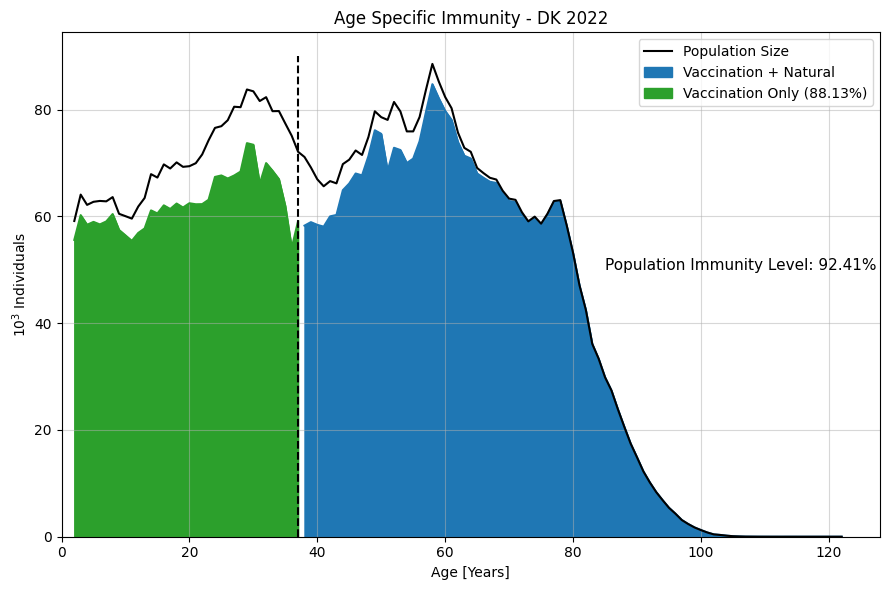

In [298]:
#pre 1987 immunity
modified_df = pd.concat([df_above,df_before])
immune_all_mod = np.average(np.asarray(modified_df['VACCINATIONRATE']), weights= np.asarray(modified_df['POPULATION']))
print(f'Overall modified immune fraction = {round(immune_all_mod*100,2)}')

# Plot the total vaccinated people as a function of birth year
plt.figure(figsize=(9, 6))
plt.plot(df_above['AGE'], df_above['Total Vaccinated']/1000,color = '#2ca02c',linestyle='-')
plt.plot(df_before['AGE'], df_before['Total Vaccinated']/1000, color='#1f77b4',linestyle='-')
plt.plot(df['AGE'], df['POPULATION']/1000, 'k-', label = "Population Size")
plt.title('Age Specific Immunity - DK 2022')
plt.xlabel('Age [Years]')
plt.ylabel(f'$10^{3}$ Individuals')
plt.grid(True, alpha = .5)
plt.vlines(x = 2022-1987+2, ymin = 0, ymax = 90, color = "black", linestyles="--")
plt.fill_between(df_before['AGE'], df_before['Total Vaccinated']/1000, color='#1f77b4', alpha=1, label = "Vaccination + Natural")
plt.fill_between(df_above['AGE'], df_above['Total Vaccinated']/1000, color='#2ca02c', alpha=1, label = f"Vaccination Only ({round(immune_post1987*100,2)}%)")

plt.tight_layout()
plt.ylim(ymin = 0)
plt.xlim(xmin = 0)

plt.text(85, 50, f"Population Immunity Level: {round(immune_all_mod*100,2)}%", fontsize=11)

plt.legend()


plt.savefig("Plots/VaxvsPop_nat.pdf", dpi = 400)
plt.show()

In [224]:
modified_df = pd.concat([df_above,df_before])
immune_all_mod = np.average(np.asarray(modified_df['VACCINATIONRATE']), weights= np.asarray(modified_df['POPULATION']))
print(f'Overall modified immune fraction = {round(immune_all_mod*100,2)}')

Overall modified immune fraction = 93.87


# Age of birth plot 
Below we plot data for the age of first time paranets and avergae age of parents getting (not nessecarily their first) children.
Data is from https://www.statistikbanken.dk/FOD11

In [176]:
#Load data
age_parent = pd.read_csv('Data/Age_of_parent.csv', sep=";")

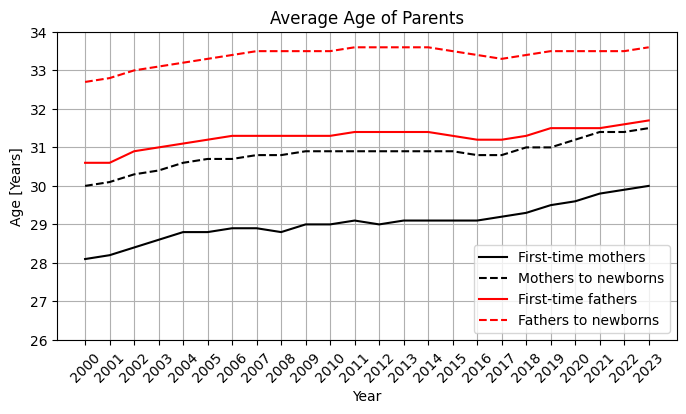

In [177]:
#Plot
plt.figure(figsize=(8,4))
plt.plot(age_parent.iloc[0,1:],  "k-",label = "First-time mothers")
plt.plot(age_parent.iloc[1,1:], "k--",label = "Mothers to newborns")
plt.plot(age_parent.iloc[2,1:], "r-",label = "First-time fathers")
plt.plot(age_parent.iloc[3,1:],"r--",label = "Fathers to newborns")

plt.xlabel('Year')
plt.ylabel('Age [Years]')
plt.title('Average Age of Parents')
plt.xticks(rotation=45)

# Adding grid
plt.grid(True)
plt.ylim(26,34)

# Displaying legend
plt.legend(loc='best')
plt.legend()
plt.savefig("Plots/age_of_parents.pdf", dpi = 400)

# Geographical MFR 1 uptake 

In [207]:
#Load data
geo_coverage = pd.read_csv('Data/Geo_covrage.csv', sep=";")
geo_new = geo_coverage.drop(1)
print(geo_new.columns)

Index(['Year', 'Kbh.+Frb', 'Koebenhavns Komm.', 'Frederiksberg komm.',
       'Koebenhvans ', 'Frederiksborg', 'Roskilde', 'Vestsjaelland',
       'Storstroems', 'Bornholms', 'Fyns', 'Soender jylland', 'Ribe', 'Vejle',
       'Ringkoebing', 'Aarhus', 'Viborg', 'Nordjylland'],
      dtype='object')


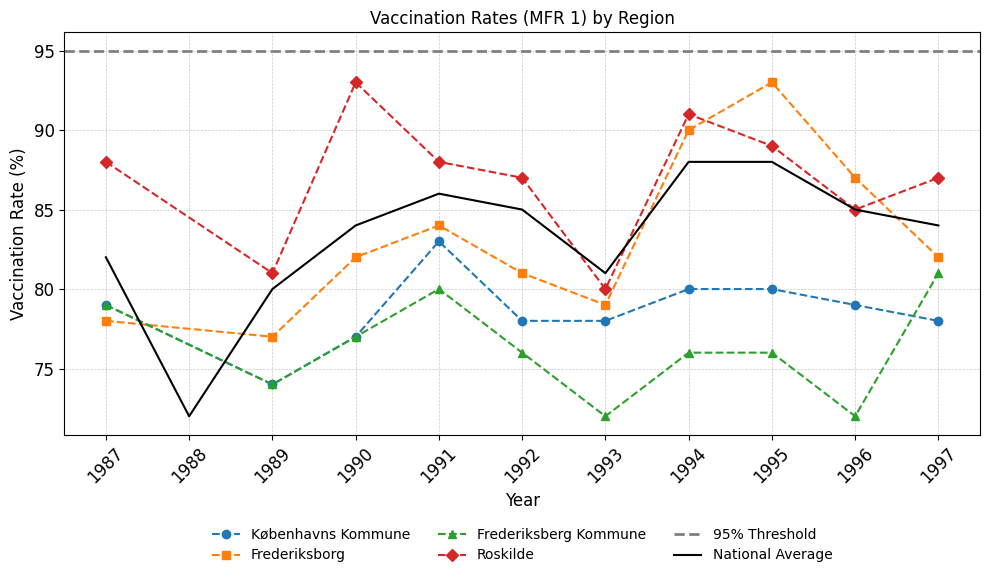

In [300]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data for each region with distinct colors and markers
ax.plot(geo_new['Year'], geo_new['Koebenhavns Komm.'], marker='o', linestyle='--', color='#1f77b4', label="Københavns Kommune")
ax.plot(geo_new['Year'], geo_new['Frederiksborg'], marker='s', linestyle='--', color='#ff7f0e', label="Frederiksborg")
ax.plot(geo_new['Year'], geo_new['Frederiksberg komm.'], marker='^', linestyle='--', color='#2ca02c', label="Frederiksberg Kommune")
ax.plot(geo_new['Year'], geo_new['Roskilde'], marker='D', linestyle='--', color='#d62728', label="Roskilde")
#ax.plot(geo_new['Year'], geo_new['Nordjylland'], marker='v', linestyle='--', color='#9467bd', label="Nordjylland")

# Plot the horizontal line at y=95%
ax.axhline(y=95, color='gray', linestyle='--', linewidth=2, label='95% Threshold')

# Plot the national average
# Ensure the data is aligned correctly; adjust slicing as necessary
national_average = np.flipud(100 * df_above['VACCINATIONRATE'][-len(geo_new['Year'])-1:])
ax.plot(geo_coverage['Year'], national_average, linestyle='-', color='black', label="National Average")

# Set axis labels with larger font sizes
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Vaccination Rate (%)', fontsize=12)

# Set the title with a larger font size
ax.set_title('Vaccination Rates (MFR 1) by Region', fontsize=12)

# Set tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust x-axis ticks if necessary
ax.set_xticks(geo_coverage['Year'])
ax.set_xticklabels(geo_coverage['Year'], rotation=45)

# Add a legend with adjusted location and font size
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=10, frameon=False)

# Add grid lines with adjusted transparency
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to prevent clipping of tick-labels and legend
plt.tight_layout()

# Save the figure in high resolution (optional)
plt.savefig('Plots/vaccination_rates_by_region.pdf', dpi=400, bbox_inches='tight')

# Display the plot
plt.show()


In [303]:
#Municipal data to extend Københavns kommune and Frederiksberg kommune coverage
#Load the municipal data
Muni_coverage = pd.read_csv('Data/Municipal_coverage.csv', sep=";")

Muni_coverage[["K�benhavn","Year","Frederiksberg"]]

kbh_cov = np.hstack([geo_new['Koebenhavns Komm.'],np.asarray(Muni_coverage["K�benhavn"])])
fred_cov = np.hstack([geo_new['Frederiksberg komm.'],np.asarray(Muni_coverage["Frederiksberg"])])

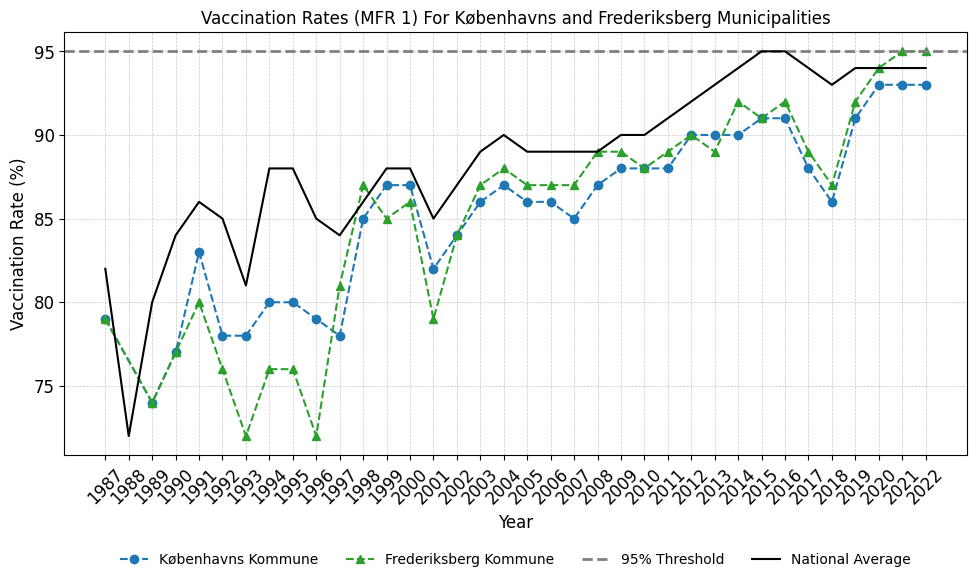

In [334]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

years = [1987+i for i in range(len(kbh_cov))]
years.pop(1)

# Plot data for each region with distinct colors and markers
ax.plot(years, kbh_cov[:-1], marker='o', linestyle='--', color='#1f77b4', label="Københavns Kommune")

ax.plot(years, fred_cov[:-1], marker='^', linestyle='--', color='#2ca02c', label="Frederiksberg Kommune")

# Plot the horizontal line at y=95%
ax.axhline(y=95, color='gray', linestyle='--', linewidth=2, label='95% Threshold')

# Plot the national average
# Ensure the data is aligned correctly; adjust slicing as necessary
national_average = np.flipud(100 * df_above['VACCINATIONRATE'])
ax.plot([1987+i for i in range(len(kbh_cov))], national_average, linestyle='-', color='black', label="National Average")

# Set axis labels with larger font sizes
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Vaccination Rate (%)', fontsize=12)

# Set the title with a larger font size
ax.set_title('Vaccination Rates (MFR 1) For København and Frederiksberg Municipalities', fontsize=12)

# Set tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust x-axis ticks if necessary
ax.set_xticks([1987+i for i in range(len(kbh_cov))])
ax.set_xticklabels([1987+i for i in range(len(kbh_cov))], rotation=45)

# Add a legend with adjusted location and font size
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=10, frameon=False)

# Add grid lines with adjusted transparency
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to prevent clipping of tick-labels and legend
plt.tight_layout()

# Save the figure in high resolution (optional)
plt.savefig('Plots/kbh_fred_vaccination_rates_by_region.pdf', dpi=400, bbox_inches='tight')

# Display the plot
plt.show()

# Age distribution of outbreaks in 5 year intervals

In [88]:
# load data
outbreak_age = pd.read_csv('Data/Outbreaks_year_age.csv', sep=";")

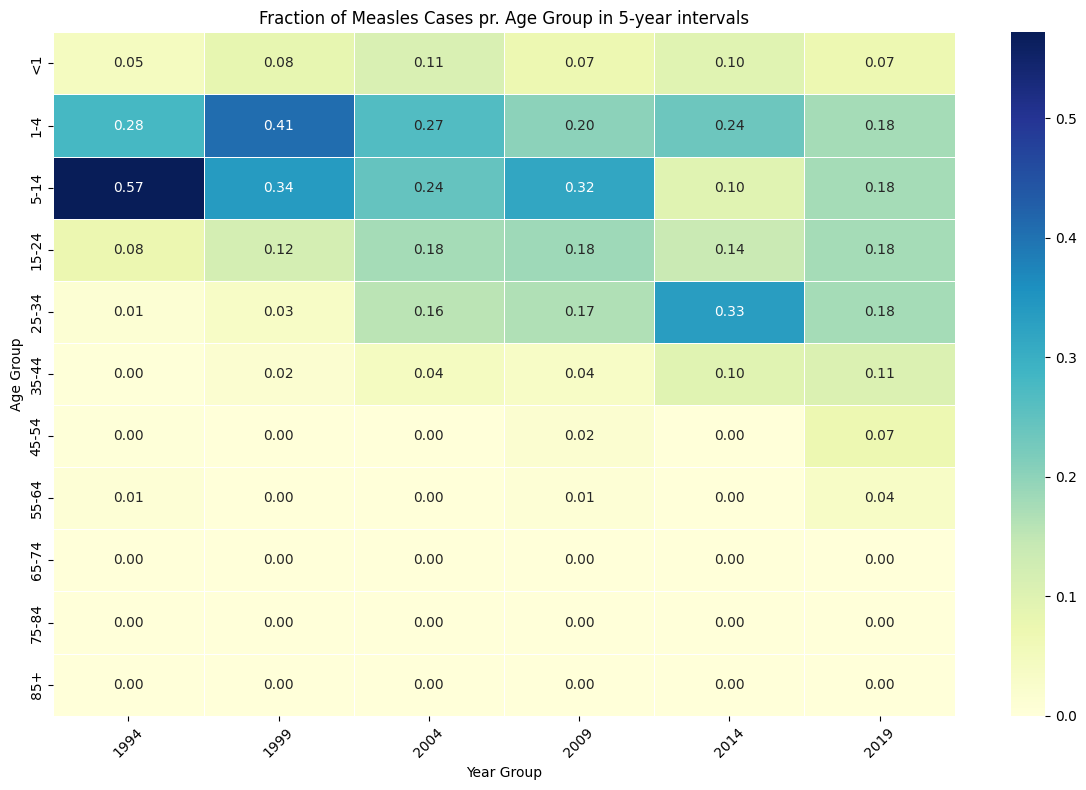

In [89]:
# First, define the starting year for your 5-year periods
start_year = outbreak_age['Year'].min()

# Create a new column 'Year_Group' that assigns each year to a 5-year period
outbreak_age['Year_Group'] = ((outbreak_age['Year'] - start_year) // 5) * 5 + start_year

# List of age group columns (excluding 'Year' and 'Year_Group')
age_group_columns = outbreak_age.columns.difference(['Year', 'Year_Group'])

# Group the DataFrame by 'Year_Group' and calculate the sum for each age group
grouped_sum = outbreak_age.groupby('Year_Group')[age_group_columns].sum()

# Calculate the total sum across all age groups for each 5-year period
grouped_sum['Total'] = grouped_sum.sum(axis=1)

# Compute the fraction for each age group by dividing by the total sum
grouped_fraction = grouped_sum[age_group_columns].div(grouped_sum['Total'], axis=0)

# Reset index to make 'Year_Group' a column again
grouped_fraction = grouped_fraction.reset_index()

grouped_fraction = grouped_fraction.drop(6)

# Set 'Year_Group' as the index to prepare for transposing
heatmap_data = grouped_fraction.set_index('Year_Group')

# Transpose the DataFrame to have age groups as rows and year groups as columns
heatmap_data = heatmap_data.transpose()

desired_order = [
    '<1',
    '1-4',
    '5-14',
    '15-24',
    '25-34',
    '35-44',
    '45-54',
    '55-64',
    '65-74',
    '75-84',
    '85+'
]

heatmap_data = heatmap_data.reindex(desired_order)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,          # Annotate cells with the numeric value
    fmt=".2f",           # Format numbers to two decimal places
    cmap='YlGnBu',       # Color map
    linewidths=0.5,      # Lines between cells
    linecolor='white'    # Line color
)

# Set the labels and title
plt.xlabel('Year Group')
plt.ylabel('Age Group')
plt.title('Fraction of Measles Cases pr. Age Group in 5-year intervals')

# Optionally, rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("Plots/Age_infect.pdf", dpi = 400)
plt.show()



Statstisk årbog records outbrekas before 1994, but in very broad age groups - 0-5, 6-15, 15 and above which are not that useful

In [90]:
#Load pre 1994 data for outbreaks
outbreak_age_pre_1994 = pd.read_csv('Data/pre_1994_outbreak.csv', sep=";")
outbreak_age_pre_1994 = outbreak_age_pre_1994.drop(["Unnamed: 4"],axis = 1)

In [100]:
# List of columns to group together
group_columns = ['15 and above']

# Columns not in group_columns
other_columns = ['<7','7 to 14']

# Sum cases for the specified group
outbreak_age_pre_1994['15_above'] = outbreak_age_pre_1994[group_columns].sum(axis=1)

# Sum cases for the other group
outbreak_age_pre_1994['15_below'] = outbreak_age_pre_1994[other_columns].sum(axis=1)

# Compute total cases per year
outbreak_age_pre_1994['Total_Cases'] = outbreak_age_pre_1994['15_above'] + outbreak_age_pre_1994['15_below']

# Compute fractions
outbreak_age_pre_1994['Fraction_above_15'] = outbreak_age_pre_1994['15_above'] / outbreak_age_pre_1994['Total_Cases']
outbreak_age_pre_1994['Fraction_below_15'] = outbreak_age_pre_1994['15_below'] / outbreak_age_pre_1994['Total_Cases']

#Do the same for data after 1993
group_columns_post1994 = ['15-24',
    '25-34',
    '35-44',
    '45-54',
    '55-64',
    '65-74',
    '75-84',
    '85+']

# All age group columns (excluding 'Year')
age_group_columns_post1994 = [col for col in outbreak_age.columns if col != 'Year' or col != 'Year_Group']

# Columns not in group_columns
other_columns_post1994 = ['5-14','1-4', '<1']

# Sum cases for the specified group
outbreak_age['15_above'] = outbreak_age[group_columns_post1994].sum(axis=1)

# Sum cases for the other group
outbreak_age['15_below'] = outbreak_age[other_columns_post1994].sum(axis=1)

# Compute total cases per year
outbreak_age['Total_Cases'] = outbreak_age['15_above'] + outbreak_age['15_below']

# Compute fractions
outbreak_age['Fraction_above_15'] = outbreak_age['15_above'] / outbreak_age['Total_Cases']
outbreak_age['Fraction_below_15'] = outbreak_age['15_below'] / outbreak_age['Total_Cases']



In [156]:
# Extract relevant columns from both DataFrames
outbreak_age_rel = outbreak_age[['Year', 'Fraction_above_15', 'Fraction_below_15','Total_Cases']]
outbreak_age_pre_1994_rel = outbreak_age_pre_1994[['Year', 'Fraction_above_15', 'Fraction_below_15','Total_Cases']]

# Combine the DataFrames
combined_df = pd.concat([outbreak_age_pre_1994_rel,outbreak_age_rel], ignore_index=True)

# Ensure 'Year' is of integer type
combined_df['Year'] = combined_df['Year'].astype(int)

# Sort the DataFrame by 'Year'
combined_df.sort_values('Year', inplace=True)

# Set 'Year' as the index
combined_df.set_index('Year', inplace=True)

combined_df = combined_df.dropna()

# Compute the rolling 5-year mean of 'Fraction_Above'
combined_df['Fraction_Above_RollingMean'] = combined_df['Fraction_above_15'].rolling(window=6, min_periods=1).mean()
combined_df['std'] = combined_df['Fraction_above_15'].rolling(window=6, min_periods=1).var()
combined_df['sum'] = combined_df['Total_Cases'].rolling(window=6, min_periods=1).sum()

# Reset the index
combined_df.reset_index(inplace=True)

# Extract the desired columns
result_df = combined_df[['Year', 'Fraction_Above_RollingMean','Fraction_above_15', 'Fraction_below_15','std','sum']]


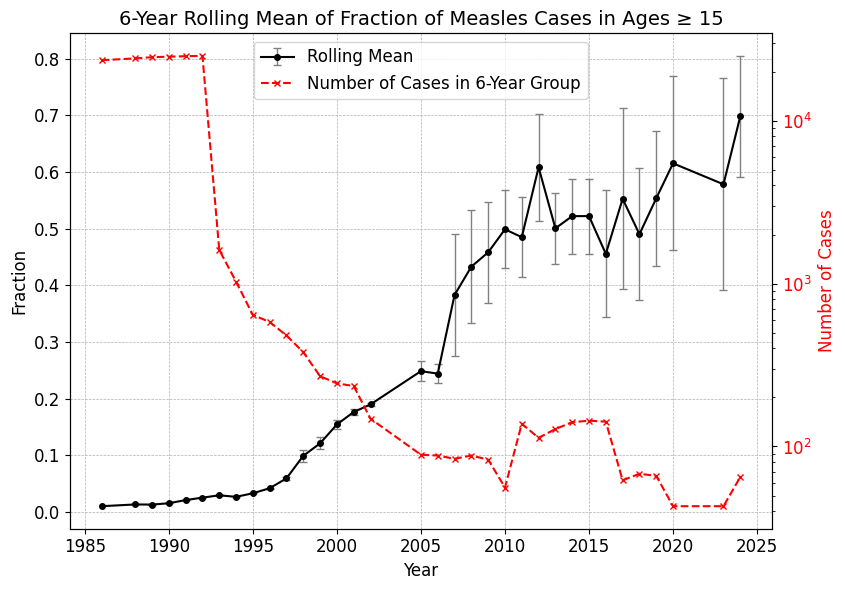

In [301]:
# Set the style for a clean

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the rolling mean with error bars
ax.errorbar(
    result_df['Year'],
    result_df['Fraction_Above_RollingMean'],
    yerr=result_df['std'],
    fmt='o-',                   # Line with circle markers
    ecolor='gray',              # Error bar color
    elinewidth=1,               # Error bar line width
    capsize=3,                  # Error bar cap size
    capthick=1,                 # Error bar cap thickness
    color='black',               # Line color
    markersize=4,   
    label = "Rolling Mean"            # Marker size
)

# Set axis labels with larger font size
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Fraction', fontsize=12)

# Set the title with larger font size
ax.set_title('6-Year Rolling Mean of Fraction of Measles Cases in Ages ≥ 15', fontsize=14)

# Set tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Add grid lines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Tight layout to ensure everything fits without overlap
plt.tight_layout()

# Create a secondary y-axis
ax2 = ax.twinx()

# Set the y-axis scale of the secondary axis to logarithmic
ax2.set_yscale('log')

# Plot the same data on the secondary axis without error bars
ax2.plot(
    result_df['Year'],
    result_df['sum'],
    color='red',
    linestyle='--',
    marker='x',
    markersize=5,
    label='Number of Cases in 6-Year Group'
)

# Set the y-axis label for the secondary axis
ax2.set_ylabel('Number of Cases', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)

# Combine legends from both axes
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', fontsize=12)



# Save the figure in high resolution (optional)
plt.savefig('Plots/measles_cases_rolling_mean.pdf', dpi=400, bbox_inches='tight')


# Display the plot
plt.show()